In [1]:
using RCall, DataFrames, LogTopReg, Distributions
import Lazy.@>, Lazy.@>>

INFO: Recompiling stale cache file /home/seth/.julia/lib/v0.5/RCall.ji for module RCall.
INFO: Using R installation at /usr/lib/R

Attaching package: ‘dplyr’

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

data.table 1.10.0
  The fastest way to learn (by data.table authors): https://www.datacamp.com/courses/data-analysis-the-data-table-way
  Documentation: ?data.table, example(data.table) and browseVignettes("data.table")
  Release notes, videos and slides: http://r-datatable.com

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [2]:
using LogTopReg
include("../juliafromR.jl");
Y,X,pss0 = getfocaldata();
Z = rcopy("Z");

  Bumped column 5 to type character on data row 6913, field contains '208B0'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they will now be just '0', and there may be inconsistencies with treatment of ',,' and ',NA,' too (if they occurred in this column before the bump). If this matters please rerun and set 'colClasses' to 'character' for this column. Please note that column type detection uses a sample of 1,000 rows (100 rows at 10 points) so hopefully this message should be very rare. If reporting to datatable-help, please rerun and include the output from verbose=TRUE.
Warning in fread(files[i]) :
  Bumped column 15 to type character on data row 57995, field contains 'sister'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they will now be just '0',

In [3]:
r = readcsv("/home/seth/analysis/logtopreg/optimout_FKKR_forpaper_6.csv");

In [4]:
zflat = mapslices(x -> rand(Categorical(x)),r,2);
z = Vector{Vector{Int64}}(length(Y));
nd = map(x -> size(x)[2],Y);
guh = 1;
for i in 1:length(Y)
    z[i] = zflat[guh:(guh+nd[i]-1)];
    guh += nd[i];
end

In [9]:
K = 6;
niter = 70000;
thin = 35;
ns = div(niter,thin);
hyper = hyperparameter(τ0_u = 0.01,ν0_u=0.33,ν0_σ2η=0.01,σ0_σ2η = 0.01,τ0_τ = 0.01,ν0_τ = 0.01,τ_β = 1.0);

In [10]:
@time fit7 = topiclmm(Y,X,Z,pss0,zinit=z,K,hyper,iter=niter,thin=thin);

23452.043090 seconds (270.00 G allocations: 9.947 TB, 4.96% gc time)


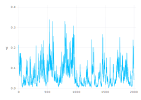

In [18]:
i = 6;
plot(y=sqrt(fit7[:σ2][i,:]),Geom.line)

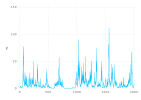

In [19]:
plot(y=sqrt(fit7[:τ_u][i,:]),Geom.line)

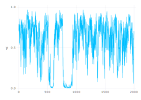

In [24]:
bl = 1;
i = 6;
f = fit7;
σ2i = f[:σ2][i,:] + f[:σ2][bl,:];
σ2Ai = f[:τ_u][i,:].*f[:σ2][i,:] + f[:τ_u][bl,:].*f[:σ2][bl,:];
h2 = σ2Ai./(σ2i.+σ2Ai)
plot(y=h2,Geom.line)

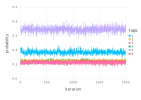

In [12]:
using Gadfly
mudat = DataFrame(probability = mapslices(softmax,fit7[:μ],1)[:],topic=repeat(map(string,1:K),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[K]));
plot(mudat,x="iteration",y="probability",color="topic",Geom.line)

In [11]:
writefit(fit7,"/home/seth/analysis/logtopreg/fitFKKR_A_6K/")